In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import tensorflow as tf
import numpy as np
# tf.device('/gpu:1')

from pprint import pprint
%matplotlib inline
import matplotlib.pyplot as plt

from Field import * # Finite Field class
#seed = 1337
#tf.set_random_seed(seed)
#np.random.seed(seed)

from pyldpc import (make_ldpc, 
                    binaryproduct, 
                    encode_random_message, 
                    decode,
                    get_message, #input：tG, x
                    encode,
                    utils,
                    coding_matrix_systematic,
                    coding_matrix)

from genCheckMatrix import GussElim
#from GA import (mat_to_vector,vector_to_mat,select_mating_pool,crossover)

In [2]:
P = 3  # Galois Field: GF{2^P}
num_iterations = 5   # number of cs-bp iterations
BATCH_SIZE = 100      # predefined batch size
NOISE_VAR = 0.01
#SPARSITY = 0.068      # predefined the sparsity of source signal

In [3]:
#ParityCheckMatrix=np.load('H(512,256,3).npy')
ParityCheckMatrix=np.load('H(128,64,3).npy')
H,G=coding_matrix(ParityCheckMatrix)
m,n=H.shape
k=G.shape[1]
coderate = k/n
num_bp_iterations = 5 

In [4]:
a=H.dot(G)
a=sum(np.mod(a[a!=0],2))
a

0

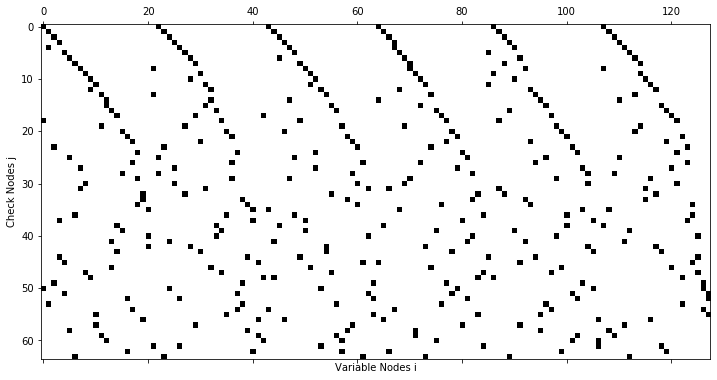

In [5]:
plt.figure(figsize=(12, 8));
plt.xlabel('Variable Nodes i');
plt.ylabel('Check Nodes j');
plt.spy(H);

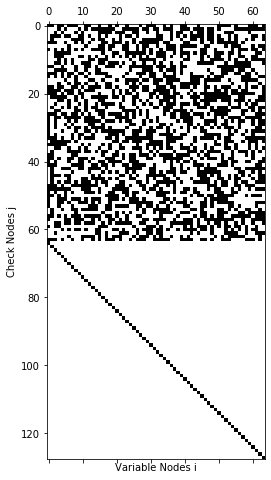

In [6]:
plt.figure(figsize=(12, 8));
plt.xlabel('Variable Nodes i');
plt.ylabel('Check Nodes j');
plt.spy(G);

In [7]:
H = tf.Variable(H, trainable=False, dtype=tf.float32)
H_unconnected = tf.cast(tf.equal(H, 0), dtype=tf.float32)
batch_size = tf.placeholder_with_default(BATCH_SIZE, shape=())
noise_var = tf.placeholder_with_default(NOISE_VAR , shape=())

In [8]:
# Generate Wash-Hadamard transform matrix for FFT accelerating
from scipy.linalg import hadamard
def wash_hadamard_transform(prob, p,dims,inverse = False):
    HADAMARD_MATRIX = hadamard(1<<p)
    # print(HADAMARD_MATRIX )
    hadarmard_mat = tf.constant(HADAMARD_MATRIX,dtype =tf.float32)
#     hadarmard_mat = tf.expand_dims(tf.expand_dims(hadarmard_mat ,axis = 0),axis = 0)
    hadarmard_prob = tf.expand_dims(prob,axis = dims) * hadarmard_mat
    transformed_prob = tf.reduce_sum(hadarmard_prob, axis = dims-1)
    # wash-hadamard inverse transform
    if inverse:  
        transformed_prob = transformed_prob / (1 << p)
    return transformed_prob

In [9]:
# Generate the source signal for Q-ary-BP
import random
def generate_source_signal(k,p,coderate):
    q = 1 << p
    x = np.random.randint(0,q-1,size=k);
    print("x: ", x)
    return x  #dims:[k]

In [10]:
# Conduct compressed sensing to source signal x and get measurement signal y
def encoder(x,p,n,k,G): #G dims:[n,k]
    from Field import FField 
    field_p = FField(p)
    y = np.zeros([n]);
    #y[k:n]=x;
    GT=G.T;#dims:[k,n]
    for i in range(n):   
        value = 0
        for j in range(k): 
            temp_value = field_p.Multiply(x[j],GT[j][i])
            value = field_p.Add(value, temp_value)
        y[i]=value
    return y  # dims:[n]

In [11]:
# Some util functions
def dec2bin(num,p):
    l = []
    while p > 0:
        num, remainder = divmod(num, 2)
        l.append(remainder)
        p = p - 1 
#     l = l.reverse()
    return l[::-1]


def bin2dec(l,p):
    value =0
    while p>0:
        value = value + l[p-1]*2**(p-1)
        p = p-1
    return value
    
def ebnodb2noisevar(ebno_db, coderate):
    ebno = 10**(ebno_db/10)
    noise_var = 1/(2*coderate*ebno)  
    return noise_var

def construct_transition_matrix(p):
    Q = 1 << p  # q = 2^p
    mat = [ dec2bin(q,p) for q in range(Q)]  # q * p
    mat = tf.transpose(tf.constant(mat,dtype = tf.float32), perm = [1,0])
    mat = 1- 2 * mat # p * q
    return mat 

# Normalize the probability
def normalization(prob,dims):
#     prob = tf.where(tf.equal(prob,0),tf.ones_like(prob)*1e-15, prob)
    H_unconnected = tf.cast(tf.equal(prob,0),dtype = tf.float32)
    sum_prob = tf.reduce_sum(prob,axis = dims-1,keepdims = True)
    norm_prob = prob / (sum_prob + H_unconnected)
    return norm_prob

In [12]:
# Transit the p-nary sequence y to awgn channel
def awgn_channel(y,p):
    binary_y = tf.constant([dec2bin(symb,p) for symb in y], shape = [n,p],dtype=tf.float32)
    bpsk_y = 2 * binary_y - 1 #dims:[n,p]
    noise = tf.random_normal(shape = [batch_size, n, p], stddev = tf.sqrt(noise_var))
    channel_outputs = bpsk_y + noise
    return channel_outputs  #dims:[batch_size, n, p]


def compute_awgn_channel_transition_probability(channel_outputs, p):
    
    transition_mat = construct_transition_matrix(p) # p * q
    transition_values =  tf.expand_dims(2 * channel_outputs / noise_var, axis = 3) # batchsize * n * p * 1 
    transition_prob_mat = 1 / (1 + tf.exp(transition_values * transition_mat)) # batchsize * n * p * q
    transition_prob = tf.reduce_prod(transition_prob_mat,axis = 2) # batchsize * n * q
    
    transition_prob = normalization(transition_prob,dims = 3)# batchsize * n * q
    transition_prob = tf.clip_by_value(transition_prob, clip_value_min = 1e-10,clip_value_max = 9.999999e-01)
    
    return transition_prob_mat, transition_prob
    # [batchsize , n , p , q],received=[batchsize , n , q]

In [13]:
# Update V2C information
def var_2_check(cv,transition_prob, H, p, init=False,final = False):  
    #wht_channel_prob = wash_hadamard_transform(transition_prob,p,3) # batchsize * n * q 
    if init:
        #Initializing posterior probability
        vc0=tf.expand_dims(tf.expand_dims(H,axis=0),axis=3)*tf.expand_dims(transition_prob,axis=1); # batch_size * m * n * q
        vc=tf.transpose(vc0,perm=[0,2,1,3]);
        return vc,vc #batch_size * n  * m  * q

    else:
        # Updating check nodes
        # dims : batchsize * n * m * q 
        H_unconnected = tf.cast(tf.equal(cv,0),dtype = tf.float32)   # batch_size * m * n * q
        H_connected = tf.cast(tf.equal(H_unconnected,0),tf.float32)  # batch_size * m * n * q       
        cv_prod = tf.reduce_prod(cv + H_unconnected , axis = 1, keepdims = True) # batchsize * 1 * n * q 
        cv_prod = tf.where(tf.equal(cv_prod,0), tf.ones_like(cv_prod) * 1e-12, cv_prod) # batchsize * 1 * n * q 
        vc= (cv_prod / (cv + H_unconnected)) * H_connected  # batchsize * m * n * q 
        vc= tf.transpose(vc,perm=[0,2,1,3]); # batchsize * n * m * q 
        vc = vc * tf.expand_dims(transition_prob,axis=2) # dims: batchsize * n * m * q 
        vc = normalization(vc, dims = 4)   #dims=[batchsize ,n ,m ,q]

       
        # Decoding decision
        # dims : batchsize * n * q 
        cv_prod_ = tf.reduce_prod(cv + H_unconnected , axis = 1) # batchsize *  n * q 
        cv_prod_ = tf.where(tf.equal(cv_prod_,0), tf.ones_like(cv_prod_) * 1e-12, cv_prod_)

        pr = cv_prod_ * transition_prob # dims : batchsize * n * q 
        pr = normalization(pr,dims = 3) # dims : batchsize * n * q  

    if final:
        return pr, pr
    else:
        return vc, pr

In [14]:
# Update C2V information
def check_2_var(vc,H, p):
    
    # Applying Wash-Hadamard transform to channel_prob
    wht_vc = wash_hadamard_transform(vc,p,4) # dims: batchsize * n * m * q
    wht_vc = tf.transpose(wht_vc,perm = [0,2,1,3]) # dims: batchsize * m * n * q
        
    
    H_unconnected = tf.cast(tf.equal(wht_vc,0),dtype = tf.float32) # dims: batchsize * m * n * q  
    H_connected = tf.cast(tf.equal(H_unconnected,0),tf.float32) # dims: batchsize * m * n * q  
    # Apdating variable nodes
    wht_vc_prod = tf.reduce_prod(wht_vc + H_unconnected, axis = 2, keepdims = True)# dims: batchsize * m * 1 * q
    wht_vc_prod = tf.where(tf.equal(wht_vc_prod,0), tf.ones_like(wht_vc_prod) * 1e-12, wht_vc_prod) # dims: batchsize * m * 1 * q
        
    wht_cv = wht_vc_prod / (wht_vc + H_unconnected) * H_connected   # dims: batchsize * m * n * q
    #wht_cv = wht_cv * tf.expand_dims(wht_channel_prob, axis = 2 ) 
        
    cv = wash_hadamard_transform(wht_cv, p, dims = 4, inverse = True) # dims: batchsize * m * n * q
    cv = normalization(cv, dims = 4) # batchsize * m * n * q  
    return cv # dims: batchsize * m * n * q

In [15]:
## --------------------------------------------------------------------------------
## -------------------------------- Encoding --------------------------------------
#信息位产生
x_list = generate_source_signal(k,P,coderate)# dims:[k]
x = tf.constant(x_list,dtype=tf.float32) 

### y = H * x (over Finite field)
y = encoder(x_list,P,n,k,G) #dims:[n]
#print('y: ',y)

recieve_y = awgn_channel(y,P)
transition_prob_mat, transition_prob = compute_awgn_channel_transition_probability(recieve_y,P)
# [batchsize , n , p , q],[batchsize , n , q]

#pr0, vc0 = init_vc(n,SPARSITY,P) # vc0 dims : n * m * q
cv=tf.zeros(shape=[batch_size,m,n,int(1<<P)])
vc = tf.zeros(shape = [batch_size, n, m, int(1<<P)])

x:  [3 3 3 6 6 5 6 1 3 0 4 6 0 1 3 3 4 6 1 5 5 5 2 1 5 1 1 0 2 1 0 6 5 6 5 2 0
 0 4 0 2 0 3 0 0 0 4 3 2 3 4 1 3 1 6 1 2 6 3 4 2 2 4 6]


In [16]:
# -----------------------------------------------------------------------------------
## -------------------------------- Decoding ----------------------------------------
W_vc=tf.placeholder_with_default(tf.ones(shape=[1,n,m,(1<<P)]),shape=[1,n,m,(1<<P)]) 
W_cv=tf.placeholder_with_default(tf.ones(shape=[1,m,n,(1<<P)]),shape=[1,m,n,(1<<P)])
for i in range(num_iterations):
    is_final = (i==num_iterations-1)
    is_init = (i==0)
    vc,logits=var_2_check(W_cv*cv, transition_prob, H, P, is_init,is_final)
    if not is_final:
        cv=check_2_var(W_vc*vc,H, P)
    #cv = check_2_var(W_vc*vc, vc0,channel_prob, H, P, is_init)  # cv dims:batchsize * m * n * q 
    #vc, pr = var_2_check(W_cv*cv, vc0, pr0, H, P, is_final)     # vc dims:batchsize * n * m * q 
    #cv = check_2_var(vc, vc0,channel_prob, H, P, is_init)  # cv dims:batchsize * m * n * q 
    #vc, pr = var_2_check(cv, vc0, pr0, H, P, is_final)     # vc dims:batchsize * n * m * q 
# pr dims: batchsize * n * q
x_hat = tf.cast(tf.argmax(logits, axis = 2), dtype = tf.float32) # batchsize * n
fer = tf.reduce_mean(tf.cast(tf.not_equal(x,x_hat[:,n-k:n]),dtype = tf.float32))
#check_fer=tf.multiply(x_hat,tf.transpose(tf.expand_dims(H,axis=0),perm=[0,2,1]))
#fer=tf.reduce_mean(tf.cast(tf.not_equal(tf.count_nonzero(check_fer,dtype=tf.float32),0.0),dtype=tf.float32));

In [17]:
# ----------------------------------------------------------------------------------
# ------------------------------ Run -----------------------------------------------
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

samples = 1000
epochs = 10
ebnos_db = np.linspace(-6,6,12)
fers_no_training = np.zeros(shape=[ebnos_db.shape[0]])

for j in range(epochs):
    for i in range(ebnos_db.shape[0]):
        ebno_db = ebnos_db[i]
        fers_no_training[i] += sess.run(fer,feed_dict={
            batch_size: samples,
            noise_var: ebnodb2noisevar(ebno_db, coderate)
        })
fers_no_training /= epochs

In [18]:
fers_no_training

array([0.66803905, 0.63226251, 0.59016562, 0.54064375, 0.47570781,
       0.39470469, 0.28268282, 0.143325  , 0.03754375, 0.00645469,
       0.01790156, 0.00800938])

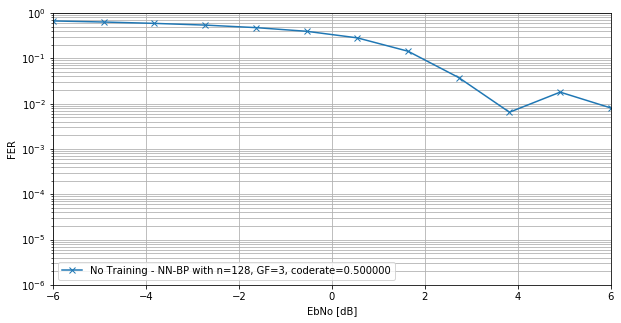

In [19]:
plt.figure(figsize=(10, 5))
plt.semilogy(ebnos_db, fers_no_training, '-x')
plt.grid(which='both');
plt.xlabel('EbNo [dB]');
plt.ylabel('FER');
plt.ylim([1e-6, 1e-0]);
plt.xlim([ebnos_db[0], ebnos_db[-1]]);
plt.legend(['No Training - NN-BP with n=%d, GF=%d, coderate=%f' % (n,P,coderate)]);

# Optimizer

In [20]:
import random

In [21]:
def unfolded_qarybp(w_vc,w_cv,epochs=5,samples=100):

    ebnos_db = np.linspace(1,4,4)
    fers_no_training = np.zeros(shape=[ebnos_db.shape[0]])

    for j in range(epochs):
        for i in range(ebnos_db.shape[0]):
            ebno_db = ebnos_db[i]
            fers_no_training[i] += sess.run(fer, feed_dict={
                W_vc:w_vc,
                W_cv:w_cv,
                batch_size: samples,
                noise_var: ebnodb2noisevar(ebno_db, coderate)
            })
    fers_no_training /= epochs
    fers_av=np.mean(fers_no_training)
    return fers_av;

In [22]:
def fitnessfunc(W_vc_population,
                W_cv_population,
                sol_per_pop=8,
                samples = 100,
                epochs = 10):
    fitness=np.zeros([sol_per_pop])
    for i in range(sol_per_pop):
        fitness[i]=unfolded_qarybp(W_vc_population[i],W_cv_population[i]);
    return fitness;

In [23]:
def mat_to_vector(mat_pop_weights):
    pop_weights_vector = []
    for sol_idx in range(mat_pop_weights.shape[0]):
        curr_vector = []
        for layer_idx in range(mat_pop_weights.shape[1]):
            vector_weights = np.reshape(mat_pop_weights[sol_idx, layer_idx], newshape=(mat_pop_weights[sol_idx, layer_idx].size))
            curr_vector.extend(vector_weights)
        pop_weights_vector.append(curr_vector)
    return np.array(pop_weights_vector)

In [24]:
def vector_to_mat(vector_pop_weights, mat_pop_weights):
    mat_weights = []
    for sol_idx in range(mat_pop_weights.shape[0]):
        start = 0
        end = 0
        for layer_idx in range(mat_pop_weights.shape[1]):
            end = end + mat_pop_weights[sol_idx, layer_idx].size
            curr_vector = vector_pop_weights[sol_idx, start:end]
            mat_layer_weights = np.reshape(curr_vector, newshape=(mat_pop_weights[sol_idx, layer_idx].shape))
            mat_weights.append(mat_layer_weights)
            start = end
    return np.reshape(mat_weights, newshape=mat_pop_weights.shape)

In [25]:
def select_mating_pool(pop_w_vc_vector, pop_w_cv_vector,fitness_, num_of_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents_of_w_vc=[];parents_of_w_cv=[];
    fitness=fitness_
    for parent_num in range(num_of_parents):
        min_fitness_idx = np.where(fitness == np.min(fitness))
        min_fitness_idx = min_fitness_idx[0][0]
        parents_of_w_vc.append(pop_w_vc_vector[min_fitness_idx, :]) # dims:[num_of_parents,(m*n*8)]
        parents_of_w_cv.append(pop_w_cv_vector[min_fitness_idx, :]) # dims:[num_of_parents,(m*n*8)]
        fitness[min_fitness_idx] = 99999999999
    return np.array(parents_of_w_vc),np.array(parents_of_w_cv)


In [26]:
def crossover(parents_of_w_vc,parents_of_w_cv, num_of_offsprings,num_of_parents,cross_point=1/2):
    offspring_of_w_vc=[];offspring_of_w_cv=[]
    offs_w_vc=np.empty([parents_of_w_vc.shape[1]])
    offs_w_cv=np.empty([parents_of_w_cv.shape[1]])
    crossover_point = np.uint8(parents_of_w_vc.shape[1]/2);
    for k in range(num_of_offsprings):
        # Index of the first parent to mate.
        parent1_idx = k%num_of_parents
        # Index of the second parent to mate.
        parent2_idx = (k+1)%num_of_parents
        # The new offspring will have its first half of its genes taken from the first parent.
        offs_w_vc[0:crossover_point] = parents_of_w_vc[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offs_w_vc[crossover_point:] = parents_of_w_vc[parent2_idx, crossover_point:]
        offs_w_cv[0:crossover_point] = parents_of_w_cv[parent1_idx, 0:crossover_point]
        offs_w_cv[crossover_point:] = parents_of_w_cv[parent2_idx, crossover_point:]
        offspring_of_w_vc.append(offs_w_vc);
        offspring_of_w_cv.append(offs_w_cv);
    return np.array(offspring_of_w_vc), np.array(offspring_of_w_cv ) 

In [27]:
def mutation(offspring_of_w_vc, offspring_of_w_cv, mutation_percent):#,mutation_degree):
    num_mutations = np.uint8((mutation_percent*offspring_of_w_cv.shape[1]))
    mutation_indices = np.array(random.sample(range(0, offspring_of_w_cv.shape[1]), num_mutations))
    for idx in range(offspring_of_w_vc.shape[0]):
        #random_value = numpy.random.uniform(-1.0*mutation_degree, 1.0*mutation_degree, 1)
        offspring_of_w_vc[idx,mutation_indices] = np.random.uniform(0.5, 2, num_mutations);
        offspring_of_w_cv[idx,mutation_indices] = np.random.uniform(0.5, 2, num_mutations);
    return offspring_of_w_vc, offspring_of_w_cv;
    

In [28]:
sol_per_pop=8;
num_generations=2000;
num_of_parents=4;
mutation_percent=0.1
num_of_offsprings=sol_per_pop-num_of_parents
accuracies = np.empty(shape=(num_generations))

In [29]:
initial_pop_w_cv = [] #dims:[sol_per_pop, 1, m, n, q]
initial_pop_w_vc = [] #dims:[sol_per_pop, 1, n, m, q]
for curr_sol in np.arange(0, sol_per_pop):
    initial_pop_w_vc.append(np.random.uniform(low=0.5, high=2.0, size=([1,n,m,(1<<P)])))
    initial_pop_w_cv.append(np.random.uniform(low=0.5, high=2.0, size=([1,m,n,(1<<P)])))
    
pop_w_cv_mat = np.array(initial_pop_w_cv) #dims:[sol_per_pop,1,m,n,q]
pop_w_vc_mat = np.array(initial_pop_w_vc) # dims:[sol_per_pop,1,n,m,q]

pop_w_cv_vector = mat_to_vector(pop_w_cv_mat) #dims:[sol_per_pop,(m*n*8)]
pop_w_vc_vector = mat_to_vector(pop_w_vc_mat) #dims:[sol_per_pop,(m*n*8)]

In [30]:
for generation in range(num_generations):
    pop_w_cv_mat = vector_to_mat(pop_w_cv_vector,pop_w_cv_mat) 
    pop_w_vc_mat = vector_to_mat(pop_w_vc_vector,pop_w_vc_mat) 
    fitness=fitnessfunc(pop_w_vc_mat,pop_w_cv_mat)
    accuracies[generation] = fitness[0]
    print("Generation{}:Fitness{}".format(generation,fitness))
    # Selecting the best parents in the population for mating.
    parents_of_w_vc,parents_of_w_cv=select_mating_pool(pop_w_vc_vector, pop_w_cv_vector,fitness.copy(), num_of_parents)
    # Generating next generation using crossover.
    offspring_of_w_vc, offspring_of_w_cv=crossover(parents_of_w_vc,parents_of_w_cv, num_of_offsprings,num_of_parents)
    # Adding some variations to the offsrping using mutation.
    offspring_of_w_vc, offspring_of_w_cv=mutation(offspring_of_w_vc, offspring_of_w_cv, mutation_percent)
    #update
    pop_w_cv_vector[0:num_of_parents]=parents_of_w_cv;
    pop_w_cv_vector[num_of_offsprings:]=offspring_of_w_cv
    pop_w_vc_vector[0:num_of_parents]=parents_of_w_vc;
    pop_w_vc_vector[num_of_offsprings:]=offspring_of_w_vc
    

Generation0:Fitness[0.06678125 0.08886458 0.08261458 0.09039063 0.08788542 0.08066667
 0.07613542 0.07546354]
Generation1:Fitness[0.06486979 0.07520833 0.0744375  0.08188021 0.06551042 0.06513021
 0.06401042 0.06532812]
Generation2:Fitness[0.06545313 0.0664375  0.06635417 0.06523438 0.06402083 0.06543229
 0.06333333 0.06425   ]
Generation3:Fitness[0.06432292 0.06640104 0.06533854 0.06551563 0.06502083 0.06591667
 0.06481771 0.06559375]
Generation4:Fitness[0.06558854 0.06654687 0.06335937 0.06565104 0.06324479 0.06508333
 0.06522917 0.06744271]
Generation5:Fitness[0.06483333 0.06542708 0.06514583 0.06531771 0.065375   0.06314063
 0.06410937 0.06336458]
Generation6:Fitness[0.06326563 0.06522917 0.06442187 0.06511979 0.06707813 0.06598438
 0.06457292 0.06315625]
Generation7:Fitness[0.065375   0.06326562 0.06365104 0.065375   0.06607292 0.06461979
 0.06476562 0.06422917]
Generation8:Fitness[0.0641875  0.06438021 0.06408854 0.06560417 0.06289062 0.06279687
 0.06391146 0.06373438]
Generation

Generation74:Fitness[0.05694792 0.05501562 0.05641146 0.05552083 0.05499479 0.05623958
 0.05583854 0.05588021]
Generation75:Fitness[0.05464583 0.05600521 0.05571875 0.05414063 0.056625   0.05695312
 0.05363542 0.05647396]
Generation76:Fitness[0.05608333 0.05601562 0.05540625 0.05665104 0.05654167 0.05697917
 0.05440104 0.05536458]
Generation77:Fitness[0.05492708 0.05482292 0.05414063 0.05716667 0.05566146 0.05582812
 0.05544792 0.05557813]
Generation78:Fitness[0.05566146 0.05624479 0.05634375 0.05584375 0.05609896 0.05555729
 0.05573958 0.05506771]
Generation79:Fitness[0.05670833 0.0555     0.05476042 0.05451042 0.05604687 0.05345312
 0.05567187 0.05534375]
Generation80:Fitness[0.05582812 0.05525    0.05592187 0.05769271 0.05644792 0.05615104
 0.05605729 0.05591667]
Generation81:Fitness[0.05409375 0.05472917 0.05523437 0.05633333 0.05530208 0.05497396
 0.05485417 0.05646354]
Generation82:Fitness[0.05417188 0.05584896 0.05525521 0.05560937 0.05766146 0.0541875
 0.05535937 0.05516667]
Ge

Generation148:Fitness[0.04959896 0.04988542 0.04795833 0.04938542 0.04813021 0.04920833
 0.04963021 0.05051042]
Generation149:Fitness[0.05015625 0.04993229 0.04849479 0.04908333 0.05094792 0.05014583
 0.0490625  0.04973958]
Generation150:Fitness[0.05072917 0.04982812 0.05007292 0.05096354 0.04842708 0.04801562
 0.05027083 0.05030208]
Generation151:Fitness[0.04908333 0.04693229 0.05001563 0.05010938 0.05010417 0.04919792
 0.04993229 0.04931771]
Generation152:Fitness[0.04746354 0.04909896 0.04941667 0.04909896 0.04900521 0.0488125
 0.04832813 0.048     ]
Generation153:Fitness[0.04921354 0.04990104 0.04863542 0.04757292 0.04717708 0.04872396
 0.04755729 0.04960417]
Generation154:Fitness[0.04890104 0.04857292 0.04772917 0.04822396 0.04947917 0.04789583
 0.04842708 0.04832292]
Generation155:Fitness[0.04968229 0.04781771 0.04893229 0.047875   0.04997396 0.04804688
 0.04997396 0.04888021]
Generation156:Fitness[0.04876562 0.04805729 0.04967187 0.04978125 0.04913542 0.04927083
 0.04925521 0.048

Generation222:Fitness[0.04505729 0.04538542 0.04608854 0.04618229 0.04594792 0.04471875
 0.04625    0.04601562]
Generation223:Fitness[0.04633854 0.04475521 0.04598437 0.04646354 0.04655729 0.04692708
 0.0449375  0.04701042]
Generation224:Fitness[0.04604167 0.04649479 0.04710417 0.04689063 0.04536979 0.04697396
 0.04633854 0.04531771]
Generation225:Fitness[0.04598958 0.04584375 0.04533333 0.04549479 0.04693229 0.04683854
 0.04548958 0.04751563]
Generation226:Fitness[0.04592708 0.04434896 0.04529167 0.04561979 0.04566667 0.04567188
 0.04680208 0.04603646]
Generation227:Fitness[0.04630208 0.04584375 0.04473438 0.04436458 0.04610417 0.04586458
 0.04563542 0.04665625]
Generation228:Fitness[0.04673958 0.04611458 0.04598437 0.04758333 0.04466146 0.04553125
 0.04380208 0.04564583]
Generation229:Fitness[0.04663021 0.04560417 0.04548958 0.04583333 0.04357292 0.04439063
 0.04569792 0.04517187]
Generation230:Fitness[0.04368229 0.04423438 0.04534375 0.04559896 0.04358333 0.04427604
 0.04506771 0.04

Generation296:Fitness[0.03998437 0.03890104 0.03868229 0.03883854 0.03875    0.038625
 0.03982292 0.03968229]
Generation297:Fitness[0.04082292 0.04022917 0.039875   0.03888542 0.03748958 0.04036979
 0.03890625 0.03905208]
Generation298:Fitness[0.03908333 0.03991146 0.04023958 0.03943229 0.039875   0.03973437
 0.03884896 0.03888021]
Generation299:Fitness[0.03926042 0.04051042 0.03964583 0.04032292 0.039      0.04014583
 0.03977083 0.0399375 ]
Generation300:Fitness[0.04076562 0.03855208 0.04004688 0.04011458 0.040625   0.03949479
 0.0398125  0.03851563]
Generation301:Fitness[0.03842187 0.0411875  0.04022917 0.03975    0.03960417 0.03976563
 0.03899479 0.03895313]
Generation302:Fitness[0.03821354 0.03874479 0.039      0.03829167 0.03955729 0.04001563
 0.03947917 0.03953125]
Generation303:Fitness[0.03922917 0.03916667 0.03891667 0.04010938 0.03896354 0.03897396
 0.03996354 0.03839583]
Generation304:Fitness[0.03866667 0.0388125  0.03915625 0.03865104 0.03831771 0.03941146
 0.03841146 0.0387

Generation370:Fitness[0.03545313 0.03670833 0.03714063 0.03657813 0.0353125  0.03598437
 0.03598958 0.0346875 ]
Generation371:Fitness[0.03580208 0.03650521 0.03554167 0.03563542 0.03466146 0.03623958
 0.03627083 0.03636979]
Generation372:Fitness[0.03484375 0.03577083 0.03693229 0.03577083 0.03544792 0.03450521
 0.03571875 0.03510937]
Generation373:Fitness[0.034625   0.03495833 0.0349375  0.03374479 0.03473958 0.03494792
 0.03467708 0.03421875]
Generation374:Fitness[0.03495833 0.03530208 0.03498958 0.03423438 0.03495313 0.03424479
 0.03382292 0.03372396]
Generation375:Fitness[0.03429688 0.03334896 0.03494271 0.03522917 0.03422396 0.03426042
 0.03548958 0.03461979]
Generation376:Fitness[0.03598958 0.03472396 0.03529167 0.03458333 0.03479687 0.03505729
 0.03467188 0.03547396]
Generation377:Fitness[0.03398437 0.03485417 0.03473958 0.03535938 0.03471354 0.0353125
 0.03531771 0.03520312]
Generation378:Fitness[0.0348125  0.03489063 0.03381771 0.03475521 0.03745833 0.03590625
 0.03632292 0.036

Generation444:Fitness[0.03251562 0.03219792 0.03205208 0.03295312 0.03227604 0.03219792
 0.03236458 0.03291667]
Generation445:Fitness[0.03323437 0.03214583 0.03106771 0.03271875 0.03240104 0.03261458
 0.03320833 0.03246354]
Generation446:Fitness[0.03317188 0.03348958 0.03302083 0.03257292 0.03194271 0.03204167
 0.03248958 0.03190104]
Generation447:Fitness[0.03238542 0.03171875 0.03339063 0.03405208 0.03299479 0.03219792
 0.03259375 0.03238021]
Generation448:Fitness[0.03242708 0.03308854 0.03143229 0.03197396 0.03351562 0.03416667
 0.03272917 0.03294792]
Generation449:Fitness[0.03147396 0.03301042 0.03385417 0.03364062 0.03113542 0.0334375
 0.03213542 0.03304687]
Generation450:Fitness[0.03280729 0.03219271 0.03188542 0.03311458 0.03230729 0.03193229
 0.0328125  0.03309375]
Generation451:Fitness[0.03122917 0.03307812 0.03271354 0.03171875 0.03314583 0.03223958
 0.03223437 0.03289063]
Generation452:Fitness[0.03233333 0.03247396 0.03366667 0.03148437 0.03263542 0.03405208
 0.03221354 0.032

Generation518:Fitness[0.03109896 0.02988542 0.03070833 0.03028125 0.0303125  0.03030729
 0.03001042 0.02922917]
Generation519:Fitness[0.02972917 0.02985417 0.03005729 0.03065104 0.02978125 0.02998958
 0.03003125 0.03081771]
Generation520:Fitness[0.03093229 0.02897396 0.03056771 0.02946875 0.02936458 0.03034896
 0.03082292 0.03016667]
Generation521:Fitness[0.03051042 0.02974479 0.02972396 0.02986979 0.03105208 0.03146354
 0.03032812 0.03041146]
Generation522:Fitness[0.03069271 0.03029167 0.02997917 0.02935938 0.03054167 0.03042708
 0.02961458 0.03090625]
Generation523:Fitness[0.03098437 0.02954687 0.03002604 0.02996875 0.02991146 0.03139583
 0.0296875  0.02908854]
Generation524:Fitness[0.03045833 0.02951562 0.030875   0.02886979 0.03060417 0.02997917
 0.02894271 0.02992188]
Generation525:Fitness[0.03021875 0.03082292 0.03136458 0.03074479 0.03008333 0.02977083
 0.02917188 0.0305625 ]
Generation526:Fitness[0.02991146 0.02916146 0.030125   0.03069792 0.03059375 0.02930729
 0.0310625  0.02

Generation592:Fitness[0.0275625  0.02710937 0.0283125  0.02743229 0.02809896 0.02753125
 0.02732292 0.02788542]
Generation593:Fitness[0.02803646 0.02803646 0.02754167 0.02867188 0.02844792 0.02734896
 0.02803125 0.02910937]
Generation594:Fitness[0.02900521 0.02738542 0.02853125 0.02694792 0.02801563 0.02876042
 0.02716667 0.02832812]
Generation595:Fitness[0.02698958 0.0273125  0.02743229 0.02925521 0.02777604 0.02851562
 0.02699479 0.02780729]
Generation596:Fitness[0.02764583 0.02743229 0.02852083 0.02792187 0.02807812 0.02778125
 0.02663542 0.02740625]
Generation597:Fitness[0.02758333 0.02885417 0.0270625  0.02672917 0.02849479 0.02926562
 0.0274375  0.02851042]
Generation598:Fitness[0.02751042 0.02669792 0.02884896 0.02814062 0.02916146 0.02821875
 0.02725    0.02714063]
Generation599:Fitness[0.02947396 0.02839583 0.02874479 0.02714583 0.02740625 0.028125
 0.02655729 0.02722917]
Generation600:Fitness[0.02764063 0.02779687 0.02801042 0.02748437 0.02776042 0.02802083
 0.02824479 0.0281

Generation666:Fitness[0.02692708 0.02698437 0.02624479 0.02685417 0.02717188 0.02702083
 0.02621875 0.02668229]
Generation667:Fitness[0.02669271 0.02654167 0.02694792 0.02751042 0.02807813 0.02786979
 0.02598958 0.02682292]
Generation668:Fitness[0.02710938 0.02657812 0.02633333 0.02816667 0.02530208 0.0259375
 0.02771875 0.02756771]
Generation669:Fitness[0.02639062 0.02696354 0.02729687 0.02651562 0.02756771 0.02698958
 0.02688021 0.02630729]
Generation670:Fitness[0.02686458 0.02690625 0.02724479 0.02711979 0.02701563 0.02665625
 0.02819271 0.02679167]
Generation671:Fitness[0.02766146 0.02682812 0.02680208 0.02744792 0.02658333 0.02811458
 0.02740104 0.02705729]
Generation672:Fitness[0.02774479 0.02660417 0.02752604 0.02801562 0.02805208 0.02745833
 0.02775    0.02790104]
Generation673:Fitness[0.02750521 0.02805729 0.02597917 0.02747917 0.02761979 0.02929167
 0.02630208 0.02672396]
Generation674:Fitness[0.02675521 0.02645833 0.02628125 0.02779167 0.02607813 0.02656771
 0.02667188 0.026

Generation740:Fitness[0.02534896 0.02542188 0.0260625  0.02629687 0.02529167 0.02554687
 0.02561458 0.02445313]
Generation741:Fitness[0.02594271 0.02644792 0.02468229 0.02609375 0.02626562 0.02646354
 0.02735417 0.02604167]
Generation742:Fitness[0.0269375  0.02619792 0.02747917 0.02653646 0.02567708 0.02547917
 0.02497396 0.02615104]
Generation743:Fitness[0.02582812 0.02589063 0.02635417 0.02561458 0.02674479 0.02686458
 0.02626563 0.02609375]
Generation744:Fitness[0.02652604 0.02599479 0.02544792 0.0264375  0.02610417 0.02523438
 0.02675    0.02613021]
Generation745:Fitness[0.02680729 0.026125   0.02527083 0.02542708 0.02740104 0.02657292
 0.02611979 0.02496354]
Generation746:Fitness[0.02635937 0.02610938 0.02514583 0.02553125 0.02640625 0.02704167
 0.02498438 0.02533333]
Generation747:Fitness[0.02708854 0.02600521 0.02641667 0.02624479 0.02589063 0.026
 0.02536458 0.02554167]
Generation748:Fitness[0.02559896 0.02704167 0.0255625  0.02594271 0.02486979 0.025875
 0.02500521 0.02545833]

Generation814:Fitness[0.02564583 0.02555208 0.02573438 0.02605729 0.02575521 0.02489583
 0.02539583 0.02525521]
Generation815:Fitness[0.02557292 0.02639583 0.02555729 0.02569792 0.02630208 0.02526562
 0.02571354 0.02645833]
Generation816:Fitness[0.02586458 0.0254375  0.02532813 0.02449479 0.02533854 0.02604688
 0.0253125  0.02616667]
Generation817:Fitness[0.02547917 0.02580208 0.02560937 0.02580208 0.02544792 0.02633854
 0.02513542 0.025     ]
Generation818:Fitness[0.02477604 0.02353125 0.02482292 0.02582292 0.02527604 0.02602604
 0.02575    0.02553125]
Generation819:Fitness[0.02528646 0.0256875  0.02563542 0.02508854 0.02535417 0.02676042
 0.02591667 0.02494792]
Generation820:Fitness[0.02547396 0.02584896 0.02450521 0.02447917 0.02476042 0.02559896
 0.02571875 0.02521875]
Generation821:Fitness[0.02631771 0.02509896 0.02453646 0.02505208 0.0251875  0.02505208
 0.02606771 0.02618229]
Generation822:Fitness[0.0248125  0.02511979 0.02520833 0.02641146 0.02555208 0.02524479
 0.02564063 0.02

Generation888:Fitness[0.02444792 0.02371354 0.02458333 0.02408854 0.02517708 0.02359896
 0.02376042 0.02388021]
Generation889:Fitness[0.02430729 0.02458333 0.02292187 0.02407292 0.02384896 0.02465625
 0.02457813 0.02413021]
Generation890:Fitness[0.02319792 0.02475    0.02379688 0.02330729 0.02452604 0.02451562
 0.02548438 0.02370313]
Generation891:Fitness[0.02336979 0.02430729 0.02406771 0.0248125  0.02304687 0.02361979
 0.02454687 0.02452604]
Generation892:Fitness[0.02365625 0.02469792 0.02495312 0.02435417 0.02468229 0.02361458
 0.02478646 0.02384375]
Generation893:Fitness[0.02536458 0.02375    0.02423958 0.02344271 0.02391146 0.02416146
 0.02484896 0.02421354]
Generation894:Fitness[0.02451042 0.02442708 0.02442187 0.02428125 0.0245625  0.02465625
 0.02451562 0.02423958]
Generation895:Fitness[0.02531771 0.0245625  0.02393229 0.02446354 0.02564062 0.02390104
 0.02546354 0.02458333]
Generation896:Fitness[0.0245625  0.02455729 0.02465625 0.02520833 0.02432813 0.02466667
 0.02488021 0.02

Generation962:Fitness[0.02382812 0.02318229 0.02294271 0.02411458 0.02279167 0.02423437
 0.02345833 0.02397396]
Generation963:Fitness[0.02372396 0.02439063 0.02280208 0.02360417 0.02228646 0.02365625
 0.02332292 0.02382812]
Generation964:Fitness[0.02331771 0.02432813 0.02332813 0.02294271 0.02279167 0.02320312
 0.02296354 0.02348958]
Generation965:Fitness[0.02295833 0.02246354 0.02373958 0.02228646 0.02359896 0.02361458
 0.02273438 0.02352083]
Generation966:Fitness[0.02236979 0.02500521 0.02316146 0.02279688 0.02279167 0.02282292
 0.02410417 0.02279687]
Generation967:Fitness[0.02178125 0.02244271 0.02429167 0.02309375 0.02257292 0.02341146
 0.02254688 0.02452083]
Generation968:Fitness[0.02313021 0.02247396 0.02325521 0.02399479 0.02452604 0.02419792
 0.02365104 0.02371354]
Generation969:Fitness[0.02202604 0.02409896 0.02341667 0.02363542 0.02273958 0.02298958
 0.02447396 0.02275521]
Generation970:Fitness[0.02315104 0.02250521 0.02323958 0.02392708 0.02338021 0.02258333
 0.02392708 0.02

Generation1035:Fitness[0.02167187 0.02205729 0.02253125 0.02227083 0.02322917 0.02189062
 0.02109896 0.02202083]
Generation1036:Fitness[0.02155729 0.02288021 0.022125   0.0219375  0.02227604 0.02278125
 0.02210417 0.02313542]
Generation1037:Fitness[0.02235417 0.0210625  0.0225625  0.0224375  0.02159896 0.02220833
 0.02229167 0.02260417]
Generation1038:Fitness[0.02181771 0.02239062 0.02236458 0.02220312 0.02242188 0.0231875
 0.02258333 0.02225   ]
Generation1039:Fitness[0.02279688 0.02244271 0.02248437 0.02197917 0.02352604 0.02277604
 0.02271875 0.02278646]
Generation1040:Fitness[0.02179687 0.02159896 0.02238542 0.02207812 0.02227604 0.02225
 0.02241667 0.02152604]
Generation1041:Fitness[0.02300521 0.02352083 0.02213021 0.02253125 0.022625   0.02296354
 0.02141667 0.02228125]
Generation1042:Fitness[0.02146354 0.02258333 0.02155208 0.02185417 0.02244792 0.02374479
 0.02209896 0.02259375]
Generation1043:Fitness[0.02102083 0.02358854 0.02209375 0.02172396 0.02251562 0.02290625
 0.02239062

Generation1108:Fitness[0.02098437 0.0210625  0.02021354 0.02023958 0.02163542 0.02065104
 0.02132292 0.02089583]
Generation1109:Fitness[0.02045313 0.02261979 0.02133854 0.02117188 0.0208125  0.02131771
 0.02073437 0.02122396]
Generation1110:Fitness[0.02095313 0.02058333 0.02082813 0.02075521 0.02100521 0.02038021
 0.02147396 0.02060417]
Generation1111:Fitness[0.02078125 0.02070313 0.02094792 0.02159375 0.01964063 0.01975521
 0.02071354 0.02063542]
Generation1112:Fitness[0.01947917 0.02028125 0.0196875  0.02077083 0.02136458 0.02014583
 0.0205     0.01995313]
Generation1113:Fitness[0.02078125 0.02110938 0.01980208 0.02053646 0.02115104 0.0203125
 0.02027604 0.02028646]
Generation1114:Fitness[0.02046875 0.02065104 0.02164583 0.02071354 0.02091667 0.02004688
 0.01993229 0.02160937]
Generation1115:Fitness[0.02070833 0.02109375 0.0208125  0.02099479 0.02072396 0.0206875
 0.01988542 0.02076042]
Generation1116:Fitness[0.020625   0.01965625 0.02054687 0.02045833 0.02054167 0.02075521
 0.02025 

Generation1181:Fitness[0.02009896 0.02051563 0.01958333 0.01942708 0.020375   0.02052604
 0.01946875 0.02073437]
Generation1182:Fitness[0.01938021 0.01864062 0.01988021 0.01936979 0.01897396 0.02040104
 0.02042187 0.02031771]
Generation1183:Fitness[0.02000521 0.01970833 0.01980208 0.01969792 0.01935937 0.02039583
 0.02023437 0.02054167]
Generation1184:Fitness[0.02064583 0.02048437 0.02033333 0.02052604 0.02097917 0.01919792
 0.02082292 0.02044271]
Generation1185:Fitness[0.01966667 0.02065625 0.02111458 0.01925521 0.02152604 0.01972396
 0.02069792 0.01954688]
Generation1186:Fitness[0.02029687 0.02122396 0.02146875 0.02075    0.01984375 0.020375
 0.02074479 0.02011979]
Generation1187:Fitness[0.01973958 0.02044792 0.01955208 0.0199375  0.02010937 0.01977083
 0.0208125  0.02026563]
Generation1188:Fitness[0.01989583 0.02015625 0.02111979 0.01984375 0.019875   0.01973437
 0.01913542 0.01934375]
Generation1189:Fitness[0.02003125 0.01958333 0.01979167 0.02061458 0.01897396 0.01988542
 0.020244

Generation1254:Fitness[0.02042188 0.01888542 0.01872917 0.01860938 0.01991667 0.01948958
 0.0184375  0.01908854]
Generation1255:Fitness[0.01979688 0.01922917 0.01908854 0.019875   0.01852083 0.02003125
 0.01930729 0.01957292]
Generation1256:Fitness[0.01906771 0.01873958 0.01859375 0.01916667 0.01906771 0.01926042
 0.01902083 0.01925521]
Generation1257:Fitness[0.01933333 0.01773438 0.01989583 0.01933854 0.01872917 0.01849479
 0.01749479 0.0184375 ]
Generation1258:Fitness[0.01925    0.01911458 0.01935417 0.01897917 0.01945833 0.01901563
 0.01869792 0.01807812]
Generation1259:Fitness[0.01859896 0.0185     0.01857292 0.01894792 0.01840625 0.01882292
 0.01886458 0.019375  ]
Generation1260:Fitness[0.0190625  0.01876042 0.01961979 0.01748958 0.01786979 0.01858854
 0.01794792 0.01894271]
Generation1261:Fitness[0.01882292 0.01824479 0.01901562 0.01942188 0.01865104 0.01772396
 0.01948438 0.01921354]
Generation1262:Fitness[0.01809375 0.01826042 0.01953125 0.01934375 0.01894792 0.01906771
 0.0185

Generation1327:Fitness[0.01913021 0.01904167 0.01963021 0.01928125 0.02071354 0.01957292
 0.01980208 0.02004167]
Generation1328:Fitness[0.02011979 0.01979687 0.01909375 0.01902604 0.01970313 0.01882292
 0.01899479 0.02001563]
Generation1329:Fitness[0.01930729 0.01915104 0.02052083 0.02035417 0.01879687 0.01921875
 0.02000521 0.0196875 ]
Generation1330:Fitness[0.02007292 0.019875   0.01959896 0.01913542 0.01928646 0.02008854
 0.01965104 0.01979688]
Generation1331:Fitness[0.01932292 0.01935938 0.01856771 0.01979167 0.02019271 0.01915104
 0.020625   0.01907812]
Generation1332:Fitness[0.02017708 0.01961979 0.01964583 0.01963021 0.01979688 0.01897396
 0.01946354 0.01958333]
Generation1333:Fitness[0.01984896 0.01864583 0.02076562 0.01951562 0.019875   0.02024479
 0.01907812 0.01984375]
Generation1334:Fitness[0.020375   0.01978125 0.01984375 0.01864583 0.02006771 0.01917187
 0.0193125  0.01963542]
Generation1335:Fitness[0.01965625 0.01967708 0.02071875 0.01995313 0.02057292 0.02035938
 0.0214

Generation1400:Fitness[0.01761979 0.01797396 0.01721354 0.01810417 0.01728646 0.01746354
 0.01788542 0.0179375 ]
Generation1401:Fitness[0.01766146 0.016875   0.01788542 0.01792188 0.01728125 0.01825
 0.01872917 0.01799479]
Generation1402:Fitness[0.01802604 0.01866146 0.01743229 0.01797917 0.01842708 0.0174375
 0.01694792 0.01816146]
Generation1403:Fitness[0.01723438 0.01859896 0.01818229 0.01633854 0.01710938 0.01756771
 0.01709896 0.0175    ]
Generation1404:Fitness[0.01691667 0.01790104 0.01703125 0.01813542 0.0174375  0.01731771
 0.01732292 0.01743229]
Generation1405:Fitness[0.01780208 0.01825521 0.01739583 0.01721875 0.01739583 0.01770313
 0.01726042 0.01765625]
Generation1406:Fitness[0.01646354 0.01697396 0.01767187 0.01794792 0.01666146 0.01802604
 0.0169375  0.01759375]
Generation1407:Fitness[0.01679167 0.01709896 0.01721875 0.01721354 0.01748958 0.01725
 0.01708854 0.01774479]
Generation1408:Fitness[0.01763021 0.017375   0.01630729 0.01746875 0.01863542 0.01790104
 0.0180625  0.

Generation1473:Fitness[0.01598438 0.01604167 0.01708333 0.01603646 0.01627604 0.01684896
 0.01696354 0.01738021]
Generation1474:Fitness[0.01613021 0.01636458 0.016375   0.01677604 0.01615625 0.01611979
 0.01635937 0.01691146]
Generation1475:Fitness[0.01657813 0.01601042 0.01675521 0.01690104 0.01669271 0.01667188
 0.01670312 0.01582812]
Generation1476:Fitness[0.01666667 0.01679688 0.01626563 0.01702083 0.01633333 0.01680208
 0.01669792 0.01802083]
Generation1477:Fitness[0.01634375 0.01696875 0.0166875  0.01729688 0.01629688 0.01591146
 0.01665104 0.0164375 ]
Generation1478:Fitness[0.01592187 0.01730208 0.01667188 0.016875   0.01805729 0.01724479
 0.01597396 0.01638542]
Generation1479:Fitness[0.01598958 0.01668229 0.0160625  0.01673438 0.01638021 0.01634375
 0.01627604 0.01647396]
Generation1480:Fitness[0.01614063 0.01632813 0.0171875  0.01677083 0.01688542 0.01609375
 0.01707812 0.01650521]
Generation1481:Fitness[0.01532813 0.01670833 0.01621875 0.01717187 0.01642708 0.01586458
 0.0167

Generation1546:Fitness[0.0154375  0.01566667 0.0166875  0.01639063 0.01541146 0.0161875
 0.01685417 0.0160625 ]
Generation1547:Fitness[0.01576562 0.01563021 0.01555208 0.01659896 0.01592187 0.01564063
 0.0164375  0.01572396]
Generation1548:Fitness[0.01593229 0.01516146 0.01645312 0.01515625 0.01535417 0.01634375
 0.01564583 0.01607292]
Generation1549:Fitness[0.01571875 0.01710938 0.01619792 0.01630729 0.01559375 0.01503125
 0.01563542 0.01416667]
Generation1550:Fitness[0.01553646 0.01524479 0.01583333 0.01617187 0.01475    0.01532292
 0.01613542 0.01586979]
Generation1551:Fitness[0.01569271 0.01598958 0.01566146 0.01564062 0.015625   0.01711458
 0.01570312 0.01633333]
Generation1552:Fitness[0.01655729 0.01453125 0.01621354 0.01589583 0.01588542 0.01633854
 0.01727083 0.01645313]
Generation1553:Fitness[0.0154375  0.01671354 0.01535938 0.01614583 0.01467708 0.01488542
 0.01509896 0.01536458]
Generation1554:Fitness[0.01504688 0.01552083 0.01513542 0.01564583 0.01660937 0.01708333
 0.01513

Generation1619:Fitness[0.01754688 0.0161875  0.01627083 0.01664583 0.01638021 0.01613021
 0.01620312 0.016875  ]
Generation1620:Fitness[0.01642188 0.01691146 0.01627083 0.01693229 0.01617188 0.01734896
 0.016      0.01517708]
Generation1621:Fitness[0.01661458 0.01572396 0.01640104 0.01629167 0.01676563 0.016
 0.01629167 0.01683854]
Generation1622:Fitness[0.01558333 0.01644792 0.01713021 0.01711979 0.01685417 0.01619271
 0.01627083 0.01614062]
Generation1623:Fitness[0.01634896 0.01619792 0.01702083 0.01639063 0.01625521 0.01677604
 0.01686979 0.01661458]
Generation1624:Fitness[0.01752604 0.01688021 0.01556771 0.01678125 0.01664583 0.01691667
 0.01672396 0.01635937]
Generation1625:Fitness[0.01569271 0.01651042 0.01630208 0.01684375 0.01695313 0.01681771
 0.01602083 0.01583854]
Generation1626:Fitness[0.01767188 0.01632813 0.01567708 0.0153125  0.01750521 0.01668229
 0.01648438 0.01560938]
Generation1627:Fitness[0.01538021 0.01610417 0.01531771 0.01577604 0.01718229 0.01598438
 0.01632812 

Generation1692:Fitness[0.01603125 0.01671354 0.01589583 0.0155625  0.01624479 0.01559896
 0.01590104 0.015375  ]
Generation1693:Fitness[0.01616146 0.01579167 0.01568229 0.01605729 0.01594792 0.01589583
 0.015625   0.01656771]
Generation1694:Fitness[0.01661979 0.01610417 0.01515625 0.01618229 0.01647917 0.01601042
 0.01584896 0.01600521]
Generation1695:Fitness[0.01594792 0.01634896 0.01635417 0.01598438 0.01578125 0.01601042
 0.01679687 0.01526562]
Generation1696:Fitness[0.01550521 0.01594271 0.01623958 0.01528646 0.01636458 0.01504167
 0.015125   0.01601562]
Generation1697:Fitness[0.01600521 0.01561979 0.015      0.01648438 0.01584375 0.01592708
 0.01578125 0.016125  ]
Generation1698:Fitness[0.01579688 0.01554688 0.01645833 0.01463542 0.01546875 0.01564583
 0.01658854 0.01567188]
Generation1699:Fitness[0.01531771 0.01547396 0.01611458 0.01620313 0.01568229 0.0150625
 0.01567708 0.01580729]
Generation1700:Fitness[0.01683333 0.01589062 0.01571875 0.01616667 0.01657812 0.01577604
 0.01662

Generation1765:Fitness[0.0154375  0.01588021 0.01502604 0.01433854 0.01520313 0.01444271
 0.01521875 0.0158125 ]
Generation1766:Fitness[0.01577604 0.01414063 0.01586979 0.01579167 0.01440104 0.015
 0.01525    0.01422917]
Generation1767:Fitness[0.01534375 0.01454167 0.01432292 0.01516146 0.01544271 0.01501042
 0.01584896 0.01580208]
Generation1768:Fitness[0.01544792 0.015625   0.01606771 0.01458854 0.01620833 0.01492708
 0.01613021 0.01525521]
Generation1769:Fitness[0.01503646 0.01546354 0.0149375  0.01510937 0.01434896 0.01566667
 0.0149375  0.01496354]
Generation1770:Fitness[0.01515625 0.01499479 0.0154375  0.01542187 0.01623438 0.0146875
 0.01445833 0.01540104]
Generation1771:Fitness[0.01532812 0.01524479 0.01451042 0.01553646 0.01471875 0.01478646
 0.01516667 0.01553125]
Generation1772:Fitness[0.01558854 0.01546354 0.01447917 0.01569271 0.01496354 0.01516146
 0.01452083 0.01495833]
Generation1773:Fitness[0.01458854 0.01563542 0.01520833 0.01498437 0.014375   0.01581771
 0.01543229 0

Generation1838:Fitness[0.01395313 0.01428125 0.01526563 0.01452604 0.01395313 0.01439583
 0.0146875  0.01377083]
Generation1839:Fitness[0.01471875 0.01476042 0.01404167 0.01558854 0.01473958 0.01477604
 0.01535417 0.01474479]
Generation1840:Fitness[0.01497917 0.01477604 0.01464583 0.01544792 0.01470313 0.01434896
 0.01489063 0.01410938]
Generation1841:Fitness[0.0148125  0.01393229 0.01454687 0.01498438 0.01439063 0.01397396
 0.01394792 0.01382292]
Generation1842:Fitness[0.01515104 0.01351563 0.01394271 0.01460417 0.01473958 0.0143125
 0.01461979 0.01488021]
Generation1843:Fitness[0.01440625 0.01376042 0.01470313 0.01386458 0.01417708 0.01425521
 0.01432292 0.01448958]
Generation1844:Fitness[0.01403646 0.01427604 0.01394271 0.01463542 0.01396875 0.01448958
 0.01416667 0.01602604]
Generation1845:Fitness[0.01438021 0.01464063 0.01425    0.01457812 0.01470313 0.01452604
 0.01411979 0.01420833]
Generation1846:Fitness[0.01397396 0.01447396 0.014625   0.01442708 0.01415625 0.01418229
 0.01412

Generation1911:Fitness[0.0141875  0.01434375 0.01506771 0.01458333 0.01403646 0.01497396
 0.01566667 0.01444792]
Generation1912:Fitness[0.01498958 0.01452604 0.01566146 0.01425521 0.01445833 0.01516146
 0.01560938 0.01508333]
Generation1913:Fitness[0.01456771 0.015375   0.014875   0.01385938 0.01519792 0.01541146
 0.01533333 0.01550521]
Generation1914:Fitness[0.01396354 0.01479688 0.01488542 0.01503125 0.01479687 0.0144375
 0.01436458 0.01468229]
Generation1915:Fitness[0.01436458 0.01368229 0.01390625 0.01415625 0.01519271 0.01546875
 0.01390625 0.01415104]
Generation1916:Fitness[0.01473437 0.01477083 0.01499479 0.01439583 0.01434896 0.0146875
 0.014875   0.01406771]
Generation1917:Fitness[0.01444792 0.01522396 0.01501563 0.01538021 0.01514583 0.01416667
 0.0159375  0.01539583]
Generation1918:Fitness[0.01483333 0.01509896 0.01401562 0.01442708 0.01500521 0.01545833
 0.01488021 0.01468229]
Generation1919:Fitness[0.01511458 0.014      0.01553125 0.01433854 0.01477604 0.01421875
 0.015484

Generation1984:Fitness[0.01420833 0.01510938 0.01446875 0.01408333 0.01541667 0.01458854
 0.01511979 0.01586979]
Generation1985:Fitness[0.01501042 0.01470312 0.01524479 0.01564583 0.01345833 0.01452604
 0.01397917 0.01373958]
Generation1986:Fitness[0.01446354 0.01472396 0.01415104 0.01490104 0.01439583 0.01432292
 0.01397396 0.01468229]
Generation1987:Fitness[0.01435417 0.01452604 0.0139375  0.01489583 0.01452083 0.01450521
 0.01451042 0.01450521]
Generation1988:Fitness[0.01485937 0.01409375 0.01354167 0.01429687 0.014375   0.01436979
 0.01454688 0.01391146]
Generation1989:Fitness[0.01485417 0.01478125 0.01492708 0.01454167 0.01495833 0.01466146
 0.01471354 0.01548437]
Generation1990:Fitness[0.014125   0.01383333 0.01453646 0.01365625 0.01402604 0.01426042
 0.01388542 0.01432812]
Generation1991:Fitness[0.01516667 0.01482292 0.01436979 0.01378125 0.01495313 0.014625
 0.01408333 0.01436979]
Generation1992:Fitness[0.01561979 0.01358854 0.01415104 0.01445312 0.01469271 0.01474479
 0.013984

In [31]:
generation

1999

In [32]:
accuracies

array([0.06678125, 0.06486979, 0.06545313, ..., 0.01460417, 0.01378646,
       0.01492708])

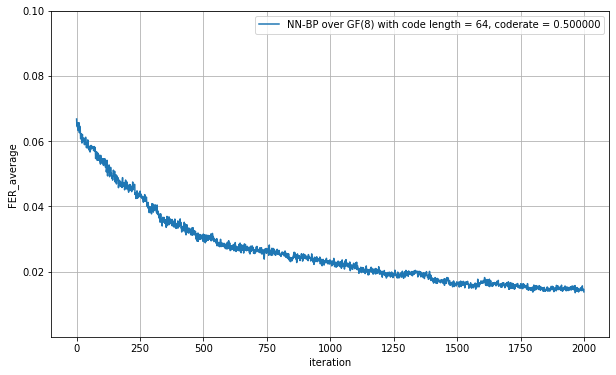

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0,generation,generation), accuracies[:generation], '-')
plt.grid(which='both');
plt.xlabel('iteration');
plt.ylabel('FER_average');
plt.ylim([1e-6, 0.1]);
plt.legend(['NN-BP over GF(%d) with code length = %d, coderate = %f' % (1<<P,k,coderate)]);

In [34]:
pop_w_cv_mat = vector_to_mat(pop_w_cv_vector,pop_w_cv_mat) 
pop_w_vc_mat = vector_to_mat(pop_w_vc_vector,pop_w_vc_mat) 
best_w_cv=pop_w_cv_mat[0]
best_w_vc=pop_w_vc_mat[0]

In [35]:
samples = 1000
epochs = 10
ebnos_db = np.linspace(-4,4,16)
fers_training = np.zeros(shape=[ebnos_db.shape[0]])

for j in range(epochs):
    for i in range(ebnos_db.shape[0]):
        ebno_db = ebnos_db[i]
        fers_training[i] += sess.run(fer, feed_dict={
            W_cv:best_w_cv,
            W_vc:best_w_vc,
            batch_size: samples,
            noise_var: ebnodb2noisevar(ebno_db, coderate)
        })
fers_training /= epochs

In [36]:
fers_training

array([0.35471094, 0.33538281, 0.31454844, 0.29096719, 0.26352188,
       0.22825781, 0.18970937, 0.14550938, 0.10320781, 0.06268594,
       0.03421719, 0.01642656, 0.00676719, 0.00264219, 0.00204062,
       0.00476563])

In [37]:
fers_no_training = np.zeros(shape=[ebnos_db.shape[0]])

for j in range(epochs):
    for i in range(ebnos_db.shape[0]):
        ebno_db = ebnos_db[i]
        fers_no_training[i] += sess.run(fer, feed_dict={
            batch_size: samples,
            noise_var: ebnodb2noisevar(ebno_db, coderate)
        })
fers_no_training /= epochs

In [38]:
fers_no_training

array([0.59967188, 0.57543592, 0.55015312, 0.52264844, 0.49076406,
       0.45606719, 0.41526406, 0.3698    , 0.31441094, 0.25005156,
       0.18080625, 0.11578906, 0.06288281, 0.02798906, 0.01034219,
       0.006325  ])

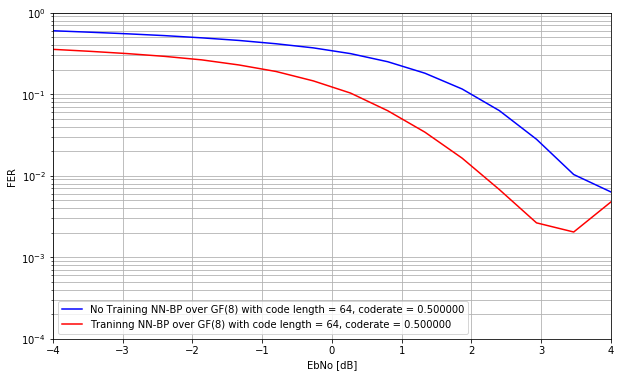

In [39]:
plt.figure(figsize=(10, 6))
plt.semilogy(ebnos_db, fers_no_training, 'b')
plt.semilogy(ebnos_db, fers_training, 'r')
plt.grid(which='both');
plt.xlabel('EbNo [dB]');
plt.ylabel('FER');
plt.ylim([1e-4, 1]);
plt.xlim([ebnos_db[0], ebnos_db[-1]]);
plt.legend(['No Training NN-BP over GF(%d) with code length = %d, coderate = %f' % (1<<P,k,coderate),
            'Traninng NN-BP over GF(%d) with code length = %d, coderate = %f' % (1<<P,k,coderate)]);